In [256]:
import os
import libsbml
import pandas as pd
import numpy as np
from collections import Counter
import re

In [214]:
# Directory
biodivine_model_dir = '/Users/luna/Desktop/CRBM/AMAS_proj/Models/BioDivine/'
biomd_model_dir = '/Users/luna/Desktop/CRBM/AMAS_proj/Models/BioModels/'
bigg_model_dir = '/Users/luna/Desktop/CRBM/AMAS_proj/Models/BiggModels/'
output_dir = '/Users/luna/Desktop/CRBM/AMAS_proj/Results/'

In [215]:
# Extract source files from BioDivine
import os
import shutil

source_directory = biodivine_model_dir + "sources"
destination_directory = biodivine_model_dir

# Ensure the destination directory exists
os.makedirs(destination_directory, exist_ok=True)
# Iterate through the subfolders in the source directory
for subfolder in os.listdir(source_directory):
    subfolder_path = os.path.join(source_directory, subfolder)
    # Check if it's a directory
    if os.path.isdir(subfolder_path):
        # Path to the 'source.sbml' file in the current subfolder
        sbml_file_path = os.path.join(subfolder_path, "source.sbml")
        # Check if the file exists
        if os.path.isfile(sbml_file_path):
            # Define the target path in the destination folder
            target_path = os.path.join(destination_directory, f"{subfolder}_source.sbml")
            # Copy the file to the destination folder
            shutil.copy(sbml_file_path, target_path)
            print(f"Copied: {sbml_file_path} to {target_path}")
        else:
            print(f"'source.sbml' not found in: {subfolder_path}")

'source.sbml' not found in: /Users/luna/Desktop/CRBM/AMAS_proj/Models/BioDivine/sources/140_BREAST-CANCER-DRUG-RESISTANCE
Copied: /Users/luna/Desktop/CRBM/AMAS_proj/Models/BioDivine/sources/204_HUMAN-BRAIN-ORGANOIDS/source.sbml to /Users/luna/Desktop/CRBM/AMAS_proj/Models/BioDivine/204_HUMAN-BRAIN-ORGANOIDS_source.sbml
'source.sbml' not found in: /Users/luna/Desktop/CRBM/AMAS_proj/Models/BioDivine/sources/233_BREAST-CANCER-SIGNALLING-PATHWAYS-T47D-COMPLETE
Copied: /Users/luna/Desktop/CRBM/AMAS_proj/Models/BioDivine/sources/149_AGS-CELL-FATE-DECISION-REDUCED/source.sbml to /Users/luna/Desktop/CRBM/AMAS_proj/Models/BioDivine/149_AGS-CELL-FATE-DECISION-REDUCED_source.sbml
Copied: /Users/luna/Desktop/CRBM/AMAS_proj/Models/BioDivine/sources/178_MAST-CELL-ACTIVATION/source.sbml to /Users/luna/Desktop/CRBM/AMAS_proj/Models/BioDivine/178_MAST-CELL-ACTIVATION_source.sbml
Copied: /Users/luna/Desktop/CRBM/AMAS_proj/Models/BioDivine/sources/127_PAMP-SIGNALING/source.sbml to /Users/luna/Desktop/CRB

In [327]:
def get_gene_annotation_string(sbml_file):
    """
    Extract GeneProducts annotatino string from an SBML-qual model.

    Parameters:
    - sbml_file (str): Path to the SBML file.

    Returns:
    - list: List of GeneProduct annotation strings.
    """
    # Read the SBML model
    reader = libsbml.SBMLReader()
    document = reader.readSBML(sbml_file)
    model = document.getModel()
    if model is None:
        print(f"Failed to read the model: {sbml_file}")
        return []
    # Check if the model uses the qual package
    qual_plugin = model.getPlugin("qual")
    if not qual_plugin:
        print(f"The model does not use the qual package: {sbml_file}")
        return []
    # Get GeneProducts from the plugin
    gene_annotations = []
    species = qual_plugin.getListOfQualitativeSpecies()
    for i in range(len(species)):
        one_species = species[i]
        annotation_string = one_species.getAnnotationString()
        gene_annotations.append(annotation_string)
    return gene_annotations

def extract_ontology_from_items(items_list):
    """
    Extract ontology from items and return a flat list of tuples.
    Each tuple contains (ontology type, ontology id).

    Parameters
    ----------
    items_list : list
        A list of string items containing ontology annotations.

    Returns
    -------
    list of tuples
        A flat list of (ontology type, ontology id).
    """
    result_identifiers = []
    for item in items_list:
        # Extract identifiers from "urn:miriam" URIs
        identifiers_list = re.findall(r'urn:miriam:([^"]+)"', item)
        for r in identifiers_list:
            ontology_type, ontology_id = r.split(":", 1)
            result_identifiers.append((ontology_type, ontology_id))
    return result_identifiers

def divideExistingAnnotation(inp_str, qualifier):
    """
    Parse the annotation string to extract items in multiple <rdf:Bag> elements 
    under the specified qualifier (e.g., <bqbiol:is>), and keep the rest in the container.
    Ensures namespaces and structure are preserved when creating an empty qualifier block.

    Parameters
    ----------
    inp_str: str
        The full annotation string.
    qualifier: str
        The qualifier to target (e.g., bqbiol:is, bqbiol:isDescribedBy).

    Returns
    -------
    dict:
        - 'container': The annotation string with the qualifier blocks replaced by a single empty block.
        - 'items': A list of <rdf:li> elements found in all <rdf:Bag> containers of the specified qualifier.
        - If no qualifier blocks are found, returns None.
    """

    # Regex to match all blocks for the specified qualifier, including attributes
    qualifier_pattern = rf"(<{qualifier}\b[^>]*?>\s*<rdf:Bag>.*?</rdf:Bag>\s*</{qualifier}>)"
    qualifier_matches = re.findall(qualifier_pattern, inp_str, re.DOTALL)

    if not qualifier_matches:
        return None  # Return None if no blocks for the qualifier are found

    # Collect all <rdf:li> elements from each matched block
    rdf_li_pattern = r"<rdf:li[^>]*\/>"
    items = []
    for block in qualifier_matches:
        items.extend(re.findall(rdf_li_pattern, block))

    # Extract the opening tag with attributes from the first match
    match_prefix = re.match(rf"<{qualifier}.*?>", qualifier_matches[0])
    if match_prefix:
        qualifier_opening = match_prefix.group()  # Capture opening tag with attributes
    else:
        qualifier_opening = f"<{qualifier}>"

    # Construct a single empty qualifier block using the preserved attributes
    empty_qualifier_block = (
        f"      {qualifier_opening}\n"
        f"        <rdf:Bag>\n"
        f"        </rdf:Bag>\n"
        f"      </{qualifier}>"
    )
    # Remove all original qualifier blocks from the container
    stripped_annotation = re.sub(qualifier_pattern, "", inp_str, flags=re.DOTALL).strip()

    # Reinsert the empty qualifier block with namespaces added
    if RDF_TAG not in stripped_annotation:
        container = stripped_annotation.replace(
            "<rdf:RDF",
            f"<{RDF_TAG}",
        )
    else:
        container = stripped_annotation

    container = container.replace(
        "</rdf:Description>",
        f"{empty_qualifier_block}\n    </rdf:Description>"
    )
    # Remove repeated blank lines
    container = re.sub(r"\n\s*\n", "\n", container)
    return {"container": container, "items": items}

def getOntologyFromString(string_annotation, description=False):
    """
    Parse string and return string annotation,
    marked as <bqbiol:is> or <bqbiol:isVersionOf>;
    (and extract the description using <bqbiol:isDescribedBy>)
    If neither exists, return None.

    Parameters
    ----------
    string_annotation: str
    description: bool
        If True, also extract the description using <bqbiol:isDescribedBy>.

    Returns
    -------
    list-tuple (ontology type, ontology id)
         Return [] if none is provided.
    """

    # Define the bqbiol qualifiers to search
    bqbiol_qualifiers = ['is', 'isVersionOf']
    if description:
        bqbiol_qualifiers.append('isDescribedBy')

    result_identifiers = []
    for one_qualifier in bqbiol_qualifiers:
        res = divideExistingAnnotation(string_annotation, 'bqbiol:' + one_qualifier)
        if res is None:
            continue
        items = res['items']
        res = extract_ontology_from_items(items)
        # remove empty lists and duplicates
        res = [r for r in res if r is not None and r != [] and r not in result_identifiers]
        result_identifiers.extend(res)

    return result_identifiers

def collect_gene_product_statistics(model_dir, overall_output_csv, model_ontology_csv, description = False):
    """
    Collect ontology statistics of GeneProducts from SBML models in a folder.

    Parameters:
    - folder_path (str): Path to the folder containing SBML models.
    - overall_output_csv (str): Path to save overall GeneProduct statistics as a CSV.
    - model_ontology_csv (str): Path to save per-model GeneProduct statistics as a CSV.
    - description (bool): If True, extract the description using <bqbiol:isDescribedBy>
    """
    overall_counter = Counter()
    model_data = []

    # Iterate over all SBML files in the folder
    model_files = [f for f in os.listdir(model_dir) if f.endswith('.xml') or f.endswith('.sbml')]
    for idx, file_name in enumerate(model_files):
      print(f"We are at {idx}: Processing {file_name}")
      file_path = os.path.join(model_dir, file_name)
      gene_annotations = get_gene_annotation_string(file_path)

      model_counter = Counter()
      for gene_annotation in gene_annotations:
        resources = getOntologyFromString(gene_annotation, description = description)
        # Count ontology types
        if resources is not None and resources != []:
            for ontology_type, ontology_id in resources:
                overall_counter[ontology_type] += 1
                model_counter[ontology_type] += 1

        # Store model-level data
        for ontology_type, count in model_counter.items():
            model_data.append({
                'model': file_name,
                'ontology_type': ontology_type,
                'count': count
            })

    # Convert overall statistics to a DataFrame
    overall_stats_df = pd.DataFrame.from_dict(overall_counter, orient='index', columns=['count'])
    overall_stats_df.reset_index(inplace=True)
    overall_stats_df.columns = ['ontology_type', 'count']

    # Convert model-specific data to a DataFrame
    model_stats_df = pd.DataFrame(model_data)

    # Save the dataframes to CSV
    overall_stats_df.to_csv(overall_output_csv, index=False)
    model_stats_df.to_csv(model_ontology_csv, index=False)
    print(f"Overall GeneProduct statistics saved to {overall_output_csv}")
    print(f"Model-specific GeneProduct statistics saved to {model_ontology_csv}")

In [320]:
res = extract_ontology_from_items(items)
res

[('hmdb', 'HMDB0001197'),
 ('chembl.compound', 'CHEMBL1232653'),
 ('wikipedia.en', 'FADH'),
 ('pubchem.compound', '446013'),
 ('chemspider', '393487'),
 ('kegg.compound', 'C01352'),
 ('cas', '146-14-5')]

In [328]:
output_csv = "/Users/luna/Desktop/CRBM/AMAS_proj/Results/biodivine_qual_ontology_statistics_no_description.csv"
model_ontology_csv = "/Users/luna/Desktop/CRBM/AMAS_proj/Results/biodivine_qual_model_ontology_statistics_no_description.csv"
collect_gene_product_statistics(biodivine_model_dir, output_csv, model_ontology_csv, description = False)

We are at 0: Processing 054_PC12-CELL-DIFFERENTIATION_source.sbml
We are at 1: Processing 038_SKBR3-BREAST-CELL-LINE-LONG-TERM_source.sbml
We are at 2: Processing 073_LYMPHOID-AND-MYELOID-CELL-SPECIFICATION_source.sbml
We are at 3: Processing 126_ORF3A_source.sbml
We are at 4: Processing 043_BORDETELLA-BRONCHISEPTICA_source.sbml
We are at 5: Processing 161_DIFFERENTIATION-OF-MONOCYTES_source.sbml
We are at 6: Processing 078_IMMUNE-SYSTEM_source.sbml
We are at 7: Processing 009_YEAST-APOPTOSIS_source.sbml
We are at 8: Processing 072_LYMPHOPOIESIS-REGULATORY-NETWORK_source.sbml
We are at 9: Processing 065_TUMOUR-CELL-INVASION-AND-MIGRATION_source.sbml
We are at 10: Processing 198_PAIR-RULE-MODULE_source.sbml
We are at 11: Processing 090_MAPK-REDUCED-2_source.sbml
We are at 12: Processing 179_MICROENVIRONMENT-CONTROL_source.sbml
We are at 13: Processing 029_TOLL-PATHWAY-OF-DROSOPHILA_source.sbml
We are at 14: Processing 010_CARDIAC-DEVELOPMENT_source.sbml
We are at 15: Processing 172_DROS

In [62]:
model_ontology = pd.read_csv("/Users/luna/Desktop/CRBM/AMAS_proj/Results/biodivine_qual_model_ontology_statistics.csv")
print(f"Total number of models: {model_ontology['model'].nunique()}")
model_ontology[model_ontology['ontology_type'] == 'ncbigene']

Total number of models: 80


,model,ontology_type,count
26,218_TCA-CYCLE_source.sbml,ncbigene,35
57,214_FOXO3-PATHWAY_source.sbml,ncbigene,60
64,216_PPARGC1A-PATHWAY_source.sbml,ncbigene,61
84,219_WNT-PI3K-AKT-PATHWAY_source.sbml,ncbigene,76
119,213_DOPAMINE-TRANSCRIPTION_source.sbml,ncbigene,60
127,111_APOPTOSIS_source.sbml,ncbigene,82
149,128_PYRIMIDINE-DEPRIVATION_source.sbml,ncbigene,27
164,119_JNK-PATHWAY_source.sbml,ncbigene,8
184,124_NSP9-PROTEIN_source.sbml,ncbigene,1
190,215_MTOR-PATHWAY_source.sbml,ncbigene,52


## Annotation statistics

In [18]:
def generate_model_species_statistics(model_dir, output_csv):
    model_statistics_data = []

    # All SBML files in the model directory
    model_files = [f for f in os.listdir(model_dir) if f.endswith('.xml') or f.endswith('.sbml')]

    for idx, model_file in enumerate(model_files):
        print(f"We are at {idx}/{len(model_files)}: Processing {model_file}")
        one_fpath = os.path.join(model_dir, model_file)
        reader = libsbml.SBMLReader()
        document = reader.readSBML(one_fpath)
        model_raw = document.getModel()
        if model_raw is None:
            print(f"Skipping {model_file} (invalid model)")
            continue
        model = model_raw.getPlugin('qual')
        recom = recommender.Recommender(libsbml_fpath=one_fpath)

        # Get species statistics
        num_species = model.getNumQualitativeSpecies()
        species2evaluate = list(recom.qual_species.exist_annotation.keys())
        num_annotated_species = len(species2evaluate)
        annotated = num_annotated_species > 0
        
        # Append the results for this species
        model_statistics_data.append({
            'model': model_file,
            'annotated': annotated,
            'num_species': num_species,
            'num_annotated_species': num_annotated_species
        })


    # Create a DataFrame from the collected data
    df = pd.DataFrame(model_statistics_data)

    # Save the DataFrame to a CSV file
    df.to_csv(output_csv, index=False)

output_csv = output_dir + "biodivine_qual_model_species_statistics.csv"
generate_model_species_statistics(biodivine_model_dir, output_csv)

We are at 0/190: Processing 054_PC12-CELL-DIFFERENTIATION_source.sbml
We are at 1/190: Processing 038_SKBR3-BREAST-CELL-LINE-LONG-TERM_source.sbml
We are at 2/190: Processing 073_LYMPHOID-AND-MYELOID-CELL-SPECIFICATION_source.sbml
We are at 3/190: Processing 126_ORF3A_source.sbml
We are at 4/190: Processing 043_BORDETELLA-BRONCHISEPTICA_source.sbml
We are at 5/190: Processing 161_DIFFERENTIATION-OF-MONOCYTES_source.sbml
We are at 6/190: Processing 078_IMMUNE-SYSTEM_source.sbml
We are at 7/190: Processing 009_YEAST-APOPTOSIS_source.sbml
We are at 8/190: Processing 072_LYMPHOPOIESIS-REGULATORY-NETWORK_source.sbml
We are at 9/190: Processing 065_TUMOUR-CELL-INVASION-AND-MIGRATION_source.sbml
We are at 10/190: Processing 198_PAIR-RULE-MODULE_source.sbml
We are at 11/190: Processing 090_MAPK-REDUCED-2_source.sbml
We are at 12/190: Processing 179_MICROENVIRONMENT-CONTROL_source.sbml
We are at 13/190: Processing 029_TOLL-PATHWAY-OF-DROSOPHILA_source.sbml
We are at 14/190: Processing 010_CARDI

In [19]:
species_statistics = pd.read_csv(output_dir + "biodivine_qual_model_species_statistics.csv")
avg_species = species_statistics['num_species'].mean()
print(f"Total number of models: {len(species_statistics)}")
print(f"Average number of species per model: {avg_species}")

Total number of models: 190
Average number of species per model: 51.73157894736842


## Test on performance

In [1]:
import os
import libsbml
import pandas as pd
import numpy as np
from collections import Counter
import re
import time
# Import my local AMAS package
import sys
sys.path.insert(0, '/Users/luna/Desktop/CRBM/AMAS_proj/AMAS-v2')
from AMAS import annotation_maker as am
from AMAS import constants as cn
from AMAS import iterator as it
from AMAS import tools
from AMAS import species_annotation as sa
from AMAS import reaction_annotation as ra 
from AMAS import gene_annotation as ga
from AMAS import recommender
from AMAS import qual_species_annotation as qsa

In [338]:
sbml = "/Users/luna/Desktop/CRBM/AMAS_proj/Models/BioDivine/111_APOPTOSIS_source.sbml"
reader = libsbml.SBMLReader()
document = reader.readSBML(sbml)
model = document.getModel()
qual_spec = model.getPlugin("qual").getQualitativeSpecies('csa11')
print(qual_spec.getAnnotationString())

<annotation>
  <rdf:RDF>
    <rdf:Description rdf:about="#s_id_sa83">
      <bqbiol:isDescribedBy>
        <rdf:Bag>
          <rdf:li rdf:resource="urn:miriam:hgnc.symbol:BCL2"/>
        </rdf:Bag>
      </bqbiol:isDescribedBy>
      <bqbiol:isDescribedBy>
        <rdf:Bag>
          <rdf:li rdf:resource="urn:miriam:hgnc.symbol:BCL2"/>
        </rdf:Bag>
      </bqbiol:isDescribedBy>
      <bqbiol:isDescribedBy>
        <rdf:Bag>
          <rdf:li rdf:resource="urn:miriam:refseq:NM_000657"/>
        </rdf:Bag>
      </bqbiol:isDescribedBy>
      <bqbiol:isDescribedBy>
        <rdf:Bag>
          <rdf:li rdf:resource="urn:miriam:ncbigene:596"/>
        </rdf:Bag>
      </bqbiol:isDescribedBy>
      <bqbiol:isDescribedBy>
        <rdf:Bag>
          <rdf:li rdf:resource="urn:miriam:ncbigene:596"/>
        </rdf:Bag>
      </bqbiol:isDescribedBy>
      <bqbiol:isDescribedBy>
        <rdf:Bag>
          <rdf:li rdf:resource="urn:miriam:uniprot:P10415"/>
        </rdf:Bag>
      </bqbiol:i

In [339]:
recom = recommender.Recommender(libsbml_fpath=sbml)
recoms = recom.getQualSpeciesListRecommendation(tax_id='9606',pred_ids=['csa11'])
recoms[0].candidates
recoms[0].labels

['BCL2L1']

In [9]:
def generate_species_accuracy(model_dir, output_csv, tax_id = '9606'):
    model_files = [f for f in os.listdir(model_dir) if f.endswith('.xml') or f.endswith('.sbml')]
    model_names = []
    taxonomy_id = []
    species_id = []
    species_name = []
    len_names = []
    exist_annotation_id = []
    exist_annotation_name = []
    predictions = []
    predictions_labels = []
    num_cands = []
    match_scores = []
    recall = []
    precision = []
    is_correct_included = []
    processing_time = []

    for idx,model_file in enumerate(model_files):
        print(f"We are at {idx}/{len(model_files)}: Processing {model_file}")
        one_fpath = os.path.join(model_dir, model_file)
        try:
            recom = recommender.Recommender(libsbml_fpath=one_fpath)
            if recom is None or recom.qual_species is None:
                print(f"Skipping {model_file} (invalid recommender or species)")
                continue
            species2evaluate = list(recom.qual_species.exist_annotation.keys())
            # run algorithm if there is at least one species to evaluate
            if species2evaluate:
                time_start = time.time()
                recoms = recom.getQualSpeciesListRecommendation(tax_id=tax_id,pred_ids=species2evaluate)
                time_end = time.time()
                recalls = recom.getQualSpeciesStatistics(tax_id=tax_id,model_mean=False)['recall']
                precisions = recom.getQualSpeciesStatistics(tax_id=tax_id,model_mean=False)['precision']
                for one_recom in recoms:
                    model_names.append(model_file)
                    taxonomy_id.append(tax_id)
                    one_spec = one_recom.id
                    species_id.append(one_spec)
                    species_name.append(recom.qual_species.getNameToUse(one_spec))
                    len_names.append(len(species_name[-1]))
                    exist_annotation_id.append(recom.qual_species.exist_annotation[one_spec])
                    exist_annotation_name.append([cn.REF_NCBI_GENE2LABEL[val] for val in recom.qual_species.exist_annotation[one_recom.id] if val in cn.REF_NCBI_GENE2LABEL])
                    predictions.append(one_recom.candidates)
                    predictions_labels.append(one_recom.labels)
                    num_cands.append(len(one_recom.candidates))
                    match_scores.append(one_recom.candidates[0][1])
                    recall.append(recalls[one_spec])
                    precision.append(precisions[one_spec])
                    processing_time.append(time_end - time_start)
                    if recall[-1] > 0:
                        is_correct_included.append(1)
                    else:
                        is_correct_included.append(0)
        except Exception as e:
            print(f"Error processing {model_file}: {str(e)}")
            continue

    # Create a DataFrame from the collected data
    spec_df = pd.DataFrame({'model': model_names,
                        'taxonomy_id': taxonomy_id,
                        'species_id': species_id,
                        'species_name': species_name,
                        'name_length': len_names,
                        'exist_annotation_id': exist_annotation_id,
                        'exist_annotation_name': exist_annotation_name,
                        'predictions': predictions,
                        'predictions_labels': predictions_labels,
                        'num_candidates': num_cands,
                        'match_score': match_scores,
                        'recall': recall,
                        'precision': precision,
                        'accuracy': is_correct_included,
                        'processing_time': processing_time})

    # Save the DataFrame to a CSV file
    spec_df.to_csv(output_csv, index=False)
    print(f"Saved to {output_csv}")

output_dir = '/Users/luna/Desktop/CRBM/AMAS_proj/Results/'
output_csv = output_dir + "biodivine_model_species_accuracy_all.csv"
generate_species_accuracy(biodivine_model_dir, output_csv)

We are at 0/190: Processing 054_PC12-CELL-DIFFERENTIATION_source.sbml
We are at 1/190: Processing 038_SKBR3-BREAST-CELL-LINE-LONG-TERM_source.sbml
We are at 2/190: Processing 073_LYMPHOID-AND-MYELOID-CELL-SPECIFICATION_source.sbml
We are at 3/190: Processing 126_ORF3A_source.sbml
We are at 4/190: Processing 043_BORDETELLA-BRONCHISEPTICA_source.sbml
We are at 5/190: Processing 161_DIFFERENTIATION-OF-MONOCYTES_source.sbml
We are at 6/190: Processing 078_IMMUNE-SYSTEM_source.sbml
We are at 7/190: Processing 009_YEAST-APOPTOSIS_source.sbml
We are at 8/190: Processing 072_LYMPHOPOIESIS-REGULATORY-NETWORK_source.sbml
We are at 9/190: Processing 065_TUMOUR-CELL-INVASION-AND-MIGRATION_source.sbml
We are at 10/190: Processing 198_PAIR-RULE-MODULE_source.sbml
We are at 11/190: Processing 090_MAPK-REDUCED-2_source.sbml
We are at 12/190: Processing 179_MICROENVIRONMENT-CONTROL_source.sbml
We are at 13/190: Processing 029_TOLL-PATHWAY-OF-DROSOPHILA_source.sbml
We are at 14/190: Processing 010_CARDI

In [14]:
def safe_eval_with_eval(x):
    try:
        return eval(x) if isinstance(x, str) else []
    except Exception as e:
        print(f"Failed to parse: {x} with error: {e}")
        return []
def print_model_accuracy(df):
    print("Number of models assessed: %d" % df['model'].nunique())
    print("Number of species assessed: %d" % df['species_id'].nunique())
    print("Average accuracy (per species) : %.003f" % df['accuracy'].mean())
    print("Average recall (per species) : %.003f" % df['recall'].mean())
    print("Average precision (per species) : %.003f" % df['precision'].mean())
    print("Average match score (per species): %.003f" % df['match_score'].mean())
    print("Average accuracy (per model): %.003f" % df.groupby('model')['accuracy'].mean().mean())
    print("Average recall (per model) : %.003f" % df.groupby('model')['recall'].mean().mean())
    print("Average precision (per model) : %.003f" % df.groupby('model')['precision'].mean().mean())
    print("Average match score (per model): %.003f" % df.groupby('model')['match_score'].mean().mean())
    
    # Fixed processing time calculations
    mean_processing_time = df.groupby('model')['processing_time'].first().mean()
    print("Ave. processing time (per model): %.003f" % mean_processing_time)
    # Calculate per element processing time
    num_elements = df.groupby('model').size().mean()
    mean_processing_time_per_element = mean_processing_time / num_elements
    print("Ave. processing time (per element, per model): %.003f" % mean_processing_time_per_element)
    # Average number of predictions per species
    df = df.copy()
    df['parsed_predictions'] = df['predictions'].apply(safe_eval_with_eval)
    df['num_predictions'] = df['parsed_predictions'].apply(len)
    average_predictions = df['num_predictions'].mean()
    print(f"Average number of predictions per row: %.003f" % average_predictions)
    
biodivine_model_species_accuracy = pd.read_csv(output_dir + "biodivine_model_species_accuracy_all.csv")
print("\n\n<Biodivine Species (All)>")
print_model_accuracy(biodivine_model_species_accuracy)



<Biodivine Species (All)>
Number of models assessed: 11
Number of species assessed: 379
Average accuracy (per species) : 0.405
Average recall (per species) : 0.399
Average precision (per species) : 0.313
Average match score (per species): 0.915
Average accuracy (per model): 0.341
Average recall (per model) : 0.336
Average precision (per model) : 0.259
Average match score (per model): 0.903
Ave. processing time (per model): 1.789
Ave. processing time (per element, per model): 0.051
Average number of predictions per row: 1.736


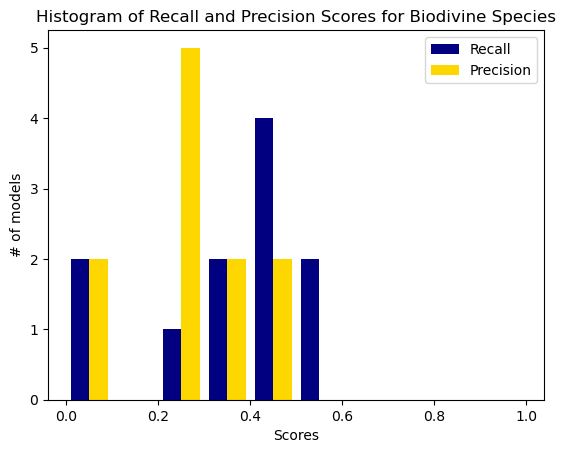

In [30]:
import matplotlib.pyplot as plt
df1 = biodivine_model_species_accuracy.groupby('model')[['recall', 'precision']].mean()
ax = plt.gca()
ax.hist(x=[df1['recall'], df1['precision']], bins=10, color=['navy', 'gold'], label=['Recall', 'Precision'], range=(0, 1))
ax.set_xlabel('Scores')
ax.set_ylabel('# of models')
ax.set_title('Histogram of Recall and Precision Scores for Biodivine Species')
ax.legend(loc='upper right')

### Try to remove everything after a symbol to query

In [4]:
s = ['TF_space_FOXO3_complex_nucleus', 'TF_space_FOXO3_complex_nucleus', 'TF_space_AP-1_complex']
t = [s.split('_', 1)[0] for s in s]
t


['TF', 'TF', 'TF']

In [1]:
import libsbml
import time
# Import my local AMAS package
import sys
sys.path.insert(0, '/Users/luna/Desktop/CRBM/AMAS_proj/AMAS-v2')
from AMAS import annotation_maker as am
from AMAS import constants as cn
from AMAS import iterator as it
from AMAS import tools
from AMAS import species_annotation as sa
from AMAS import reaction_annotation as ra 
from AMAS import gene_annotation as ga
from AMAS import recommender
from AMAS import qual_species_annotation as qsa

In [2]:
sbml = "/Users/luna/Desktop/CRBM/AMAS_proj/Models/BioDivine/214_FOXO3-PATHWAY_source.sbml"
recom = recommender.Recommender(libsbml_fpath=sbml)
species2evaluate = list(recom.qual_species.exist_annotation.keys())
tax_id = '9606'
recoms = recom.getQualSpeciesListRecommendation(tax_id=tax_id,pred_ids=species2evaluate)

Input strings: MAPK14_phosphorylated
Input strings after cleaning: MAPK14
Input strings: FOXO3_acetylated_phosphorylated_phosphorylated_phosphorylated
Input strings after cleaning: FOXO3
Input strings: FOXO3_acetylated_phosphorylated_phosphorylated
Input strings after cleaning: FOXO3
Input strings: MAPK9_nucleus
Input strings after cleaning: MAPK9
Input strings: GPX1_rna
Input strings after cleaning: GPX1
Input strings: MAPK8
Input strings after cleaning: MAPK8
Input strings: FIS1_rna
Input strings after cleaning: FIS1
Input strings: HSPD1
Input strings after cleaning: HSPD1
Input strings: FOXO3_neuron
Input strings after cleaning: FOXO3
Input strings: GABARAPL1_rna
Input strings after cleaning: GABARAPL1
Input strings: LONP1
Input strings after cleaning: LONP1
Input strings: BNIP3L_rna
Input strings after cleaning: BNIP3L
Input strings: SIRT3
Input strings after cleaning: SIRT3
Input strings: MAPK9_phosphorylated
Input strings after cleaning: MAPK9
Input strings: DNM1L_rna
Input strin

In [11]:
def generate_species_accuracy(model_dir, output_csv, tax_id = '9606'):
    model_files = [f for f in os.listdir(model_dir) if f.endswith('.xml') or f.endswith('.sbml')]
    model_names = []
    taxonomy_id = []
    species_id = []
    species_name = []
    len_names = []
    exist_annotation_id = []
    exist_annotation_name = []
    predictions = []
    predictions_labels = []
    num_cands = []
    match_scores = []
    recall = []
    precision = []
    is_correct_included = []
    processing_time = []

    for idx,model_file in enumerate(model_files):
        print(f"We are at {idx}/{len(model_files)}: Processing {model_file}")
        one_fpath = os.path.join(model_dir, model_file)
        try:
            recom = recommender.Recommender(libsbml_fpath=one_fpath)
            if recom is None or recom.qual_species is None:
                print(f"Skipping {model_file} (invalid recommender or species)")
                continue
            species2evaluate = list(recom.qual_species.exist_annotation.keys())
            # run algorithm if there is at least one species to evaluate
            if species2evaluate:
                time_start = time.time()
                recoms = recom.getQualSpeciesListRecommendation(tax_id=tax_id,pred_ids=species2evaluate)
                time_end = time.time()
                recalls = recom.getQualSpeciesStatistics(tax_id=tax_id,model_mean=False)['recall']
                precisions = recom.getQualSpeciesStatistics(tax_id=tax_id,model_mean=False)['precision']
                for one_recom in recoms:
                    model_names.append(model_file)
                    taxonomy_id.append(tax_id)
                    one_spec = one_recom.id
                    species_id.append(one_spec)
                    species_name.append(recom.qual_species.getNameToUse(one_spec))
                    len_names.append(len(species_name[-1]))
                    exist_annotation_id.append(recom.qual_species.exist_annotation[one_spec])
                    exist_annotation_name.append([cn.REF_NCBI_GENE2LABEL[val] for val in recom.qual_species.exist_annotation[one_recom.id] if val in cn.REF_NCBI_GENE2LABEL])
                    predictions.append(one_recom.candidates)
                    predictions_labels.append(one_recom.labels)
                    num_cands.append(len(one_recom.candidates))
                    match_scores.append(one_recom.candidates[0][1])
                    recall.append(recalls[one_spec])
                    precision.append(precisions[one_spec])
                    processing_time.append(time_end - time_start)
                    if recall[-1] > 0:
                        is_correct_included.append(1)
                    else:
                        is_correct_included.append(0)
        except Exception as e:
            print(f"Error processing {model_file}: {str(e)}")
            continue

    # Create a DataFrame from the collected data
    spec_df = pd.DataFrame({'model': model_names,
                        'taxonomy_id': taxonomy_id,
                        'species_id': species_id,
                        'species_name': species_name,
                        'name_length': len_names,
                        'exist_annotation_id': exist_annotation_id,
                        'exist_annotation_name': exist_annotation_name,
                        'predictions': predictions,
                        'predictions_labels': predictions_labels,
                        'num_candidates': num_cands,
                        'match_score': match_scores,
                        'recall': recall,
                        'precision': precision,
                        'accuracy': is_correct_included,
                        'processing_time': processing_time})

    # Save the DataFrame to a CSV file
    spec_df.to_csv(output_csv, index=False)
    print(f"Saved to {output_csv}")

def safe_eval_with_eval(x):
    try:
        return eval(x) if isinstance(x, str) else []
    except Exception as e:
        print(f"Failed to parse: {x} with error: {e}")
        return []
def print_model_accuracy(df):
    print("Number of models assessed: %d" % df['model'].nunique())
    print("Number of species assessed: %d" % df['species_id'].nunique())
    print("Average accuracy (per species) : %.003f" % df['accuracy'].mean())
    print("Average recall (per species) : %.003f" % df['recall'].mean())
    print("Average precision (per species) : %.003f" % df['precision'].mean())
    print("Average match score (per species): %.003f" % df['match_score'].mean())
    print("Average accuracy (per model): %.003f" % df.groupby('model')['accuracy'].mean().mean())
    print("Average recall (per model) : %.003f" % df.groupby('model')['recall'].mean().mean())
    print("Average precision (per model) : %.003f" % df.groupby('model')['precision'].mean().mean())
    print("Average match score (per model): %.003f" % df.groupby('model')['match_score'].mean().mean())
    
    # Fixed processing time calculations
    mean_processing_time = df.groupby('model')['processing_time'].first().mean()
    print("Ave. processing time (per model): %.003f" % mean_processing_time)
    # Calculate per element processing time
    num_elements = df.groupby('model').size().mean()
    mean_processing_time_per_element = mean_processing_time / num_elements
    print("Ave. processing time (per element, per model): %.003f" % mean_processing_time_per_element)
    # Average number of predictions per species
    df = df.copy()
    df['parsed_predictions'] = df['predictions'].apply(safe_eval_with_eval)
    df['num_predictions'] = df['parsed_predictions'].apply(len)
    average_predictions = df['num_predictions'].mean()
    print(f"Average number of predictions per row: %.003f" % average_predictions)
    

In [4]:
# underscore
output_dir = '/Users/luna/Desktop/CRBM/AMAS_proj/Results/'
biodivine_model_dir = '/Users/luna/Desktop/CRBM/AMAS_proj/Models/BioDivine/'
output_csv = output_dir + "biodivine_model_species_accuracy_all_underscore.csv"
generate_species_accuracy(biodivine_model_dir, output_csv)

We are at 0/190: Processing 054_PC12-CELL-DIFFERENTIATION_source.sbml
We are at 1/190: Processing 038_SKBR3-BREAST-CELL-LINE-LONG-TERM_source.sbml
We are at 2/190: Processing 073_LYMPHOID-AND-MYELOID-CELL-SPECIFICATION_source.sbml
We are at 3/190: Processing 126_ORF3A_source.sbml
We are at 4/190: Processing 043_BORDETELLA-BRONCHISEPTICA_source.sbml
We are at 5/190: Processing 161_DIFFERENTIATION-OF-MONOCYTES_source.sbml
We are at 6/190: Processing 078_IMMUNE-SYSTEM_source.sbml
We are at 7/190: Processing 009_YEAST-APOPTOSIS_source.sbml
We are at 8/190: Processing 072_LYMPHOPOIESIS-REGULATORY-NETWORK_source.sbml
We are at 9/190: Processing 065_TUMOUR-CELL-INVASION-AND-MIGRATION_source.sbml
We are at 10/190: Processing 198_PAIR-RULE-MODULE_source.sbml
We are at 11/190: Processing 090_MAPK-REDUCED-2_source.sbml
We are at 12/190: Processing 179_MICROENVIRONMENT-CONTROL_source.sbml
We are at 13/190: Processing 029_TOLL-PATHWAY-OF-DROSOPHILA_source.sbml
We are at 14/190: Processing 010_CARDI

In [15]:
biodivine_model_species_accuracy_underscore = pd.read_csv(output_dir + "biodivine_model_species_accuracy_all_underscore.csv")
print("\n\n<Biodivine Species (Underscore)>")
print_model_accuracy(biodivine_model_species_accuracy_underscore)



<Biodivine Species (Underscore)>
Number of models assessed: 11
Number of species assessed: 379
Average accuracy (per species) : 0.820
Average recall (per species) : 0.804
Average precision (per species) : 0.650
Average match score (per species): 0.985
Average accuracy (per model): 0.730
Average recall (per model) : 0.716
Average precision (per model) : 0.551
Average match score (per model): 0.973
Ave. processing time (per model): 1.849
Ave. processing time (per element, per model): 0.053
Average number of predictions per row: 1.877


In [18]:
acc0 = biodivine_model_species_accuracy_underscore[biodivine_model_species_accuracy_underscore['accuracy'] == 0]
complex_species_count = acc0[acc0['species_name'].str.contains('complex')].shape[0]
print(f"Number of rows in acc0 where 'species_name' contains 'complex': {complex_species_count}/{acc0.shape[0]}")

Number of rows in acc0 where 'species_name' contains 'complex': 58/69
